In [128]:
#这是去掉所有迭代试错后的版本，能完整体现出网络构建->训练->分析的流程

In [129]:
#学号：10185501402 姓名：孙秋实 课程：专业英语

In [130]:
#1.先导入函数

In [135]:
import numpy as np
import random
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [136]:
# 导入损失函数，形式仿造了nndl中处理MINST的代码
class QuadraticCost(object):
    @staticmethod
    def fn(a, y):
        #"""Return the cost associated with an output `a` and desired output`y`.
        return 0.5*np.linalg.norm(a-y)**2
    
    @staticmethod
    def delta(z, a, y):
        #Return the error delta from the output layer.
        return (a-y) * sigmoid_prime(z)

In [137]:
#同样地，仿造nndl中处理MINST的代码引入交叉熵损失函数
class CrossEntropyCost(object):
    @staticmethod
    def fn(a, y):
        '''Return the cost associated with an output ``a`` and desired output
        ``y``.  Note that np.nan_to_num is used to ensure numerical
        stability.  In particular, if both ``a`` and ``y`` have a 1.0
        in the same slot, then the expression (1-y)*np.log(1-a)
        returns nan.  The np.nan_to_num ensures that that is converted
        to the correct value (0.0).'''
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))
    @staticmethod
    def delta(z, a, y):
        """Return the error delta from the output layer.  Note that the
        parameter ``z`` is not used by the method.  It is included in
        the method's parameters in order to make the interface
        consistent with the delta method for other cost classes.

        """
        return (a-y)

In [138]:
#2.神经网络的基本节构

In [139]:
#仿造nndl中的神经网络结构
class Network(object):
    #传入sizes参数构建神经网络的全连接层，默认使用交叉熵代价函数和默认权重初始化
    def __init__(self, sizes, cost=CrossEntropyCost):
        """The list ``sizes`` contains the number of neurons in the respective
        layers of the network.  For example, if the list was [2, 3, 1]
        then it would be a three-layer network, with the first layer
        containing 2 neurons, the second layer 3 neurons, and the
        third layer 1 neuron.  The biases and weights for the network
        are initialized randomly, using
        ``self.default_weight_initializer`` (see docstring for that
        method).

        """
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.default_weight_initializer()
        self.cost = cost
        
        #需要实现对权重的初始化
        #这里使用两种权重初始化方式，默认权重初始化为均值为0，标准差为1的高斯分布随机分布。第二种权重初始化后均值为0，标准差为(1/n)^{1/2}，避免隐藏神经元饱和
    def default_weight_initializer(self):
        """Initialize each weight using a Gaussian distribution with mean 0
        and standard deviation 1 over the square root of the number of
        weights connecting to the same neuron.  Initialize the biases
        using a Gaussian distribution with mean 0 and standard
        deviation 1.
        Note that the first layer is assumed to be an input layer, and
        by convention we won't set any biases for those neurons, since
        biases are only ever used in computing the outputs from later
        layers.
        """
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(self.sizes[:-1], self.sizes[1:])]
    def large_weight_initializer(self):
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x) for x, y in zip(self.sizes[:-1], self.sizes[1:])]
        #实现前馈函数->用训练好的权重和偏置来计算网络输出（Test Dataset）
    def Feed_forward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a
    
    #接下来是神经网络的核心函数：随机梯度下降
    def SGD(self, training_data, epochs, mini_batch_size, eta, 
            Lambda = 0.0, 
            evaluation_data=None,
            monitor_evaluation_accuracy=False):
        
        if evaluation_data: n_data = len(evaluation_data)
        n = len(training_data)
        
        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []
        
        #每个迭代期将训练集随机打乱，将数据集分成多个mini-batch
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            
            for mini_batch in mini_batches:
                self.update_mini_batch(
                    mini_batch, eta, Lambda, len(training_data))
            print("Epoch %s" % j)
            
            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(evaluation_data)
                evaluation_accuracy.append(accuracy)
                print("Accuracy on evaluation data: {} / {}".format(self.accuracy(evaluation_data), n_data))
                
        return evaluation_accuracy
    
    
    def update_mini_batch(self, mini_batch, eta, Lambda, n):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [(1-eta*(Lambda/n))*w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]
        
    #反向传播算法计算权重和偏置
    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)
    #判断网络输出和数据集相同的个数
    def accuracy(self, data):
        results = [(np.argmax(self.Feed_forward(x)), np.argmax(y))
                       for (x, y) in data]
        return sum(int(x == y) for (x, y) in results)
    def total_cost(self, data, Lambda):
        cost = 0.0
        for x, y in data:
            a = self.Feed_forward(x)
            cost += self.cost.fn(a, y) / len(data)
        cost += 0.5*(Lambda/len(data))*sum(np.linalg.norm(w)**2 for w in self.weights)
        return cost
    
    #把神经网络的结构，权重，偏置和代价函数保存到json格式文件中
    """Save the neural network to the file ``filename``."""
    def save(self, filename):
        data = {"sizes": self.sizes,
                "weights": [w.tolist() for w in self.weights],
                "biases": [b.tolist() for b in self.biases],
                "cost": str(self.cost.__name__)}
        f = open(filename, "w")
        json.dump(data, f) #写入json
        f.close()

In [140]:
#3.Miscellaneous Functions

In [141]:
#### Miscellaneous functions
def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the j'th position
    and zeroes elsewhere.  This is used to convert a digit (0...9)
    into a corresponding desired output from the neural network.

    """
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

In [142]:
#4.接下来是导入蘑菇菇数据集

In [143]:
def vectorized(i):
    e = np.zeros((2,1))
    e[i] = 1
    return e
#向量化

In [144]:
def data_loader():
    # preprocessing
    data = pd.read_csv('mushrooms.csv')
    encoder = preprocessing.LabelEncoder()
    for Colum in data.columns:
        data[Colum] = encoder.fit_transform(data[Colum])
    data = np.array(data)
    
    train_dataset, test_dataset = train_test_split(data, test_size = 0.25)#split test data and train data
    
    #process input and output and label
    train_output = [x[0] for x in train_dataset]
    train_in = np.array([x[1:] for x in train_dataset]).astype('float')
    test_out = [x[0] for x in test_dataset]
    test_in = np.array([x[1:] for x in test_dataset]).astype('float')
    
    
    # practice vectorization
    train_out_vec = [vectorized(y) for y in train_output]
    train_in_vec = [np.reshape(x, (22,1)) for x in train_in]
    
    test_out_vec = [vectorized(y) for y in test_out]
    test_in_vec = [np.reshape(x, (22,1)) for x in test_in]
    
    train_datas = list(zip(train_in_vec, train_out_vec))
    test_datas = list(zip(test_in_vec, test_out_vec))
    
    #divided datasets
    return train_datas, test_datas

# if __name__ == "__main__":
#     train_datas, test_datas = data_loader()
#     print(train_datas[0])

In [145]:
# 训练集：测试集 = 3：1
train_datas, test_datas = data.data_loader()
num_of_test = len(test_datas)

# 神经网络的参数，可以设置很多组来对比，后面会绘制一些图来说明这里的详细调试情况！
layers = [22,65,120,2]
epochs = 20
mini_batch = 10
eta = 0.2
lmbda = 0.5

In [146]:
best_fit_paras = Network(layers, cost=QuadraticCost)
best_fit_paras.large_weight_initializer()#先要初始化!!
test_of_accuracy_one = best_fit_paras.SGD(train_datas, epochs, mini_batch, eta, evaluation_data = test_datas, monitor_evaluation_accuracy = True)

Epoch 0
Accuracy on evaluation data: 2762 / 3250
Epoch 1
Accuracy on evaluation data: 2931 / 3250
Epoch 2
Accuracy on evaluation data: 3016 / 3250
Epoch 3
Accuracy on evaluation data: 3030 / 3250
Epoch 4
Accuracy on evaluation data: 3072 / 3250
Epoch 5
Accuracy on evaluation data: 3123 / 3250
Epoch 6
Accuracy on evaluation data: 3168 / 3250
Epoch 7
Accuracy on evaluation data: 3184 / 3250
Epoch 8
Accuracy on evaluation data: 3191 / 3250
Epoch 9
Accuracy on evaluation data: 3217 / 3250
Epoch 10
Accuracy on evaluation data: 3227 / 3250
Epoch 11
Accuracy on evaluation data: 3231 / 3250
Epoch 12
Accuracy on evaluation data: 3238 / 3250
Epoch 13
Accuracy on evaluation data: 3216 / 3250
Epoch 14
Accuracy on evaluation data: 3244 / 3250
Epoch 15
Accuracy on evaluation data: 3230 / 3250
Epoch 16
Accuracy on evaluation data: 3237 / 3250
Epoch 17
Accuracy on evaluation data: 3233 / 3250
Epoch 18
Accuracy on evaluation data: 3243 / 3250
Epoch 19
Accuracy on evaluation data: 3233 / 3250


In [90]:
test_of_accuracy_one = best_fit_paras.SGD(train_datas, epochs, mini_batch, eta, evaluation_data = test_datas, monitor_evaluation_accuracy = True)

Epoch 0
Accuracy on evaluation data: 2754 / 3250
Epoch 1
Accuracy on evaluation data: 2933 / 3250
Epoch 2
Accuracy on evaluation data: 2963 / 3250
Epoch 3
Accuracy on evaluation data: 3048 / 3250
Epoch 4
Accuracy on evaluation data: 3052 / 3250
Epoch 5
Accuracy on evaluation data: 3043 / 3250
Epoch 6
Accuracy on evaluation data: 3095 / 3250
Epoch 7
Accuracy on evaluation data: 3081 / 3250
Epoch 8
Accuracy on evaluation data: 3131 / 3250
Epoch 9
Accuracy on evaluation data: 3205 / 3250
Epoch 10
Accuracy on evaluation data: 3208 / 3250
Epoch 11
Accuracy on evaluation data: 3221 / 3250
Epoch 12
Accuracy on evaluation data: 3227 / 3250
Epoch 13
Accuracy on evaluation data: 3219 / 3250
Epoch 14
Accuracy on evaluation data: 3230 / 3250
Epoch 15
Accuracy on evaluation data: 3224 / 3250
Epoch 16
Accuracy on evaluation data: 3238 / 3250
Epoch 17
Accuracy on evaluation data: 3212 / 3250
Epoch 18
Accuracy on evaluation data: 3240 / 3250
Epoch 19
Accuracy on evaluation data: 3223 / 3250
Epoch 20
A

In [97]:
best_fit_paras.save("model.json")

In [98]:
import json
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']  #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False    #用来正常显示负号


In [105]:
import json
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']  #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False    #用来正常显示负号

def mkplot(epochs, ls1, ls2, label1, label2, title):
    
    fig, ax = plt.subplots()
    
    ax.plot(np.arange(1,epochs+1,1), ls1, 'rx--', color = 'red', label = label1)
    ax.plot(np.arange(1,epochs+1,1), ls2, 'rx--', color = 'blue', label = label2)
    
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title(title)
    
    plt.grid(linestyle='-.')
    plt.legend(loc = 'best')
    plt.savefig(title)
    
    plt.show()

In [108]:
# 对比1 分别使用交叉熵和二次代价函数
def Cost_Function_Comparison():
    
    net_cost_compare_quadratic = Network(layers, cost= QuadraticCost)
    net_cost_compare_crossentropy= Network(layers, cost= CrossEntropyCost)
    
    net_cost_compare_quadratic.large_weight_initializer()
    net_cost_compare_crossentropy.large_weight_initializer()
    
    evaluation_cost_function_accuracy1 = net_cost_compare_quadratic.SGD(train_datas, epochs, mini_batch, eta, evaluation_data = test_datas, monitor_evaluation_accuracy = True)
    evaluation_cost_function_accuracy2 = net_cost_compare_crossentropy.SGD(train_datas, epochs, mini_batch, eta, evaluation_data = test_datas, monitor_evaluation_accuracy = True)
    
    
    #画图 
    mkplot(epochs,evaluation_cost_function_accuracy1, evaluation_cost_function_accuracy2, "二次代价函数", "交叉熵代价函数", "代价函数对准确度的影响")
    

Epoch 0
Accuracy on evaluation data: 2684 / 3250
Epoch 1
Accuracy on evaluation data: 2886 / 3250
Epoch 2
Accuracy on evaluation data: 3035 / 3250
Epoch 3
Accuracy on evaluation data: 3019 / 3250
Epoch 4
Accuracy on evaluation data: 3117 / 3250
Epoch 5
Accuracy on evaluation data: 3164 / 3250
Epoch 6
Accuracy on evaluation data: 3181 / 3250
Epoch 7
Accuracy on evaluation data: 3131 / 3250
Epoch 8
Accuracy on evaluation data: 3207 / 3250
Epoch 9
Accuracy on evaluation data: 3228 / 3250
Epoch 10
Accuracy on evaluation data: 3217 / 3250
Epoch 11
Accuracy on evaluation data: 3236 / 3250
Epoch 12
Accuracy on evaluation data: 3223 / 3250
Epoch 13
Accuracy on evaluation data: 3241 / 3250
Epoch 14
Accuracy on evaluation data: 3242 / 3250
Epoch 15
Accuracy on evaluation data: 3244 / 3250
Epoch 16
Accuracy on evaluation data: 3249 / 3250
Epoch 17
Accuracy on evaluation data: 3248 / 3250
Epoch 18
Accuracy on evaluation data: 3247 / 3250
Epoch 19
Accuracy on evaluation data: 3249 / 3250
Epoch 0
Ac

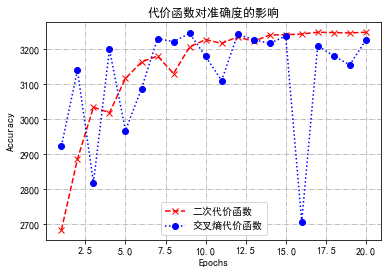

In [107]:
Cost_Function_Comparison()

In [1]:
# 隐藏层调参数
#三组数据还算是有点代表性，但事实上训练量够了以后准确度都很高

def Layers_Comparison():
    layer1 = [22,15,2]
    layer2 = [22,35,2]
    layer3 = [22,45,66,2]
    
    net_layer1 = Network(layer1, cost=mynetwork.QuadraticCost)
    net_layer2 = Network(layer2, cost=mynetwork.QuadraticCost)
    net_layer3 = Network(layer3, cost=mynetwork.QuadraticCost)
    
    net_layer1.large_weight_initializer()
    net_layer2.large_weight_initializer()
    net_layer3.large_weight_initializer()

    evaluation_layer_accuracy1 = net_layer1.SGD(train_datas, epochs, mini_batch, eta, evaluation_data = test_datas, monitor_evaluation_accuracy = True)
    evaluation_layer_accuracy2 = net_layer2.SGD(train_datas, epochs, mini_batch, eta, evaluation_data = test_datas, monitor_evaluation_accuracy = True)
    evaluation_layer_accuracy3 = net_layer3.SGD(train_datas, epochs, mini_batch, eta, evaluation_data = test_datas, monitor_evaluation_accuracy = True)
    
    fig, ax = plt.subplots()
    
    ax.plot(np.arange(1,epochs+1,1), evaluation_layer_accuracy1, 'rx--', color='steelblue', label = 'Layer:[22,15,2]')
    ax.plot(np.arange(1,epochs+1,1), evaluation_layer_accuracy2, 'rx--', color='blue', label = 'Layer:[22,35,2]')
    ax.plot(np.arange(1,epochs+1,1), evaluation_layer_accuracy3, 'rx--', color='yellow', label = 'Layer:[22,45,66,2]')
    
    #设置下图像参数
    ax.set_xlim([1,20])
    
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title('不同隐藏层对比')
    
    plt.rcParams['font.sans-serif']=['SimHei']  #用来正常显示中文标签
    plt.rcParams['axes.unicode_minus']=False    #用来正常显示负号
    plt.grid(linestyle='-.')
    plt.legend(loc='best')
    #plt.savefig('CompareofLayers')
    
    plt.show()

In [117]:
#Mini_batch 对比
def Mini_Batch_Comparison():
    batch_size1 = 10
    batch_size2 = 20
    batch_size3 = 30
    batch_size4 = 40
    layers=[22,15,120,2]
    
    batch_test_net1 = Network(layers, cost=QuadraticCost)
    batch_test_net2 = Network(layers, cost=QuadraticCost)
    batch_test_net3 = Network(layers, cost=QuadraticCost)
    batch_test_net4 = Network(layers, cost=QuadraticCost)
    
    batch_test_net1.large_weight_initializer()
    batch_test_net2.large_weight_initializer()
    batch_test_net3.large_weight_initializer()
    batch_test_net4.large_weight_initializer()

    evaluation_batchsize_accuracy1 = batch_test_net1.SGD(train_datas, epochs, batch_size1, eta, evaluation_data = test_datas, monitor_evaluation_accuracy = True)
    evaluation_batchsize_accuracy2 = batch_test_net2.SGD(train_datas, epochs, batch_size2, eta, evaluation_data = test_datas, monitor_evaluation_accuracy = True)
    evaluation_batchsize_accuracy3 = batch_test_net3.SGD(train_datas, epochs, batch_size3, eta, evaluation_data = test_datas, monitor_evaluation_accuracy = True)
    evaluation_batchsize_accuracy4 = batch_test_net4.SGD(train_datas, epochs, batch_size4, eta, evaluation_data = test_datas, monitor_evaluation_accuracy = True)
    
    fig, ax = plt.subplots()
    
    ax.plot(np.arange(1,epochs+1,1), evaluation_batchsize_accuracy1, 'rx--', color='red', label = 'MiniBatchSize=10')
    ax.plot(np.arange(1,epochs+1,1), evaluation_batchsize_accuracy2, 'rx--', color='blue', label = 'MiniBatchSize=20')
    ax.plot(np.arange(1,epochs+1,1), evaluation_batchsize_accuracy3, 'rx--', color='olive', label = 'MiniBatchSize=30')
    ax.plot(np.arange(1,epochs+1,1), evaluation_batchsize_accuracy4, 'rx--', color='green', label = 'MiniBatchSize=40')
    
    ax.set_xlim([1,25])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title('Batch大小对准确度的影响')
    
    plt.grid(linestyle='-.')
    plt.legend(loc='best')
    plt.savefig('CompareofMinibatch')
    plt.show()

Epoch 0
Accuracy on evaluation data: 2765 / 3250
Epoch 1
Accuracy on evaluation data: 2953 / 3250
Epoch 2
Accuracy on evaluation data: 3017 / 3250
Epoch 3
Accuracy on evaluation data: 3021 / 3250
Epoch 4
Accuracy on evaluation data: 3076 / 3250
Epoch 5
Accuracy on evaluation data: 3036 / 3250
Epoch 6
Accuracy on evaluation data: 3122 / 3250
Epoch 7
Accuracy on evaluation data: 3133 / 3250
Epoch 8
Accuracy on evaluation data: 3168 / 3250
Epoch 9
Accuracy on evaluation data: 3126 / 3250
Epoch 10
Accuracy on evaluation data: 3202 / 3250
Epoch 11
Accuracy on evaluation data: 3205 / 3250
Epoch 12
Accuracy on evaluation data: 3204 / 3250
Epoch 13
Accuracy on evaluation data: 3222 / 3250
Epoch 14
Accuracy on evaluation data: 3066 / 3250
Epoch 15
Accuracy on evaluation data: 3243 / 3250
Epoch 16
Accuracy on evaluation data: 3245 / 3250
Epoch 17
Accuracy on evaluation data: 3242 / 3250
Epoch 18
Accuracy on evaluation data: 3236 / 3250
Epoch 19
Accuracy on evaluation data: 3244 / 3250
Epoch 0
Ac

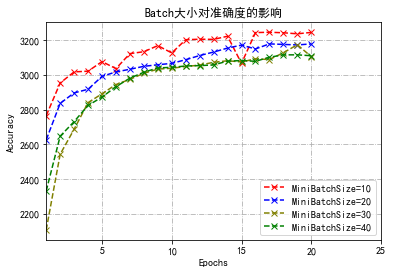

In [118]:
Mini_Batch_Comparison()

In [119]:
def Reg_Analysis():
# 调试正则化参数

    lambda1 = 0.1
    lambda2 = 0.5
    lambda3 = 5
    lambda4 = 25
    lambda5 = 100
    
#     net_reg_1 = Network(layers, cost= CrossEntropyCost)
#     net_reg_2 = Network(layers, cost= CrossEntropyCost)
#     net_reg_3 = Network(layers, cost= CrossEntropyCost)
#     net_reg_4 = Network(layers, cost= CrossEntropyCost)
#     net_reg_5 = Network(layers, cost= CrossEntropyCost)
    
    net_reg_1 = Network(layers, cost= QuadraticCost)
    net_reg_2 = Network(layers, cost= QuadraticCost)
    net_reg_3 = Network(layers, cost= QuadraticCost)
    net_reg_4 = Network(layers, cost= QuadraticCost)
    net_reg_5 = Network(layers, cost= QuadraticCost)
    
    net_reg_1.large_weight_initializer()
    net_reg_2.large_weight_initializer()
    net_reg_3.large_weight_initializer()
    net_reg_4.large_weight_initializer()
    net_reg_5.large_weight_initializer()
    
    evaluation_reg_ccuracy1 = net_reg_1.SGD(train_datas, epochs, mini_batch, eta, lmbda = lambda1, evaluation_data = test_datas, monitor_evaluation_accuracy = True)
    evaluation_reg_accuracy2 = net_reg_2.SGD(train_datas, epochs, mini_batch, eta, lmbda = lambda2, evaluation_data = test_datas, monitor_evaluation_accuracy = True)
    evaluation_reg_accuracy3 = net_reg_3.SGD(train_datas, epochs, mini_batch, eta, lmbda = lambda3, evaluation_data = test_datas, monitor_evaluation_accuracy = True)
    evaluation_reg_accuracy4 = net_reg_4.SGD(train_datas, epochs, mini_batch, eta, lmbda = lambda4, evaluation_data = test_datas, monitor_evaluation_accuracy = True)
    evaluation_reg_accuracy5 = net_reg_4.SGD(train_datas, epochs, mini_batch, eta, lmbda = lambda5, evaluation_data = test_datas, monitor_evaluation_accuracy = True)
    
    fig, ax = plt.subplots()
    
    ax.plot(np.arange(1,epochs+1,1), evaluation_reg_accuracy1, 'x-', color='olive', label = r'$\lambda=0.05$')
    ax.plot(np.arange(1,epochs+1,1), evaluation_reg_accuracy2, 'x-', color='steelblue', label = r'$\lambda=0.5$')
    ax.plot(np.arange(1,epochs+1,1), evaluation_reg_accuracy3, 'x-', color='violet', label = r'$\lambda=5$')
    ax.plot(np.arange(1,epochs+1,1), evaluation_reg_accuracy4, 'x-', color='orange', label = r'$\lambda=25$')
    ax.plot(np.arange(1,epochs+1,1), evaluation_reg_accuracy5, 'x-', color='teal', label = r'$\lambda=100$')
    
    ax.set_xlim([1,20])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title('正则化参数对准确率的影响')
    plt.grid(linestyle='-.')
    plt.legend(loc='best')
    
   # plt.savefig('Analysis Of lambda')
    plt.show()

Epoch 0 
Accuracy on evaluation data: 2788 / 3250
Epoch 1 
Accuracy on evaluation data: 2947 / 3250
Epoch 2 
Accuracy on evaluation data: 3039 / 3250
Epoch 3 
Accuracy on evaluation data: 3066 / 3250
Epoch 4 
Accuracy on evaluation data: 3100 / 3250
Epoch 5 
Accuracy on evaluation data: 3136 / 3250
Epoch 6 
Accuracy on evaluation data: 3155 / 3250
Epoch 7 
Accuracy on evaluation data: 3173 / 3250
Epoch 8 
Accuracy on evaluation data: 3173 / 3250
Epoch 9 
Accuracy on evaluation data: 3193 / 3250
Epoch 10 
Accuracy on evaluation data: 2666 / 3250
Epoch 11 
Accuracy on evaluation data: 3216 / 3250
Epoch 12 
Accuracy on evaluation data: 3196 / 3250
Epoch 13 
Accuracy on evaluation data: 3214 / 3250
Epoch 14 
Accuracy on evaluation data: 3238 / 3250
Epoch 15 
Accuracy on evaluation data: 3246 / 3250
Epoch 16 
Accuracy on evaluation data: 3243 / 3250
Epoch 17 
Accuracy on evaluation data: 3091 / 3250
Epoch 18 
Accuracy on evaluation data: 3249 / 3250
Epoch 19 
Accuracy on evaluation data: 32

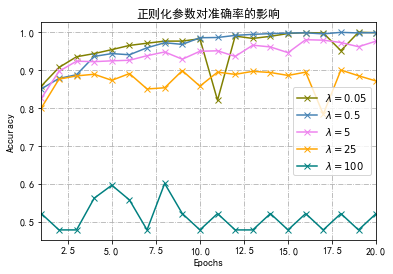

In [120]:
Reg_analysis()

In [124]:
# 学习速率对比


def Eta_analysis():
    eta1 = 0.1
    eta2 = 0.5
    eta3 = 0.8
    eta4 = 1.0
    
    net_eta_1 = Network(layers, cost= QuadraticCost)
    net_eta_2 = Network(layers, cost= QuadraticCost)
    net_eta_3 = Network(layers, cost= QuadraticCost)
    net_eta_4 = Network(layers, cost= QuadraticCost)
    
    net_eta_1.large_weight_initializer()
    net_eta_2.large_weight_initializer()
    net_eta_3.large_weight_initializer()
    net_eta_4.large_weight_initializer()

    evaluation_eta_accuracy1 = net_eta_1.SGD(train_datas, epochs, mini_batch, eta1, evaluation_data = test_datas, monitor_evaluation_accuracy = True)
    evaluation_eta_accuracy2 = net_eta_2.SGD(train_datas, epochs, mini_batch, eta2, evaluation_data = test_datas, monitor_evaluation_accuracy = True)
    evaluation_eta_accuracy3 = net_eta_3.SGD(train_datas, epochs, mini_batch, eta3, evaluation_data = test_datas, monitor_evaluation_accuracy = True)
    evaluation_eta_accuracy4 = net_eta_4.SGD(train_datas, epochs, mini_batch, eta4, evaluation_data = test_datas, monitor_evaluation_accuracy = True)
    
    fig, ax = plt.subplots()
    
    ax.plot(np.arange(1,epochs+1,1), evaluation_eta_accuracy1, 'x-', color='orange', label = 'Eta=0.1')
    ax.plot(np.arange(1,epochs+1,1), evaluation_eta_accuracy2, 'x-', color='red', label = 'Eta=0.5')
    ax.plot(np.arange(1,epochs+1,1), evaluation_eta_accuracy3, 'x-', color='dodgerblue', label = 'Eta=0.8')
    ax.plot(np.arange(1,epochs+1,1), evaluation_eta_accuracy4, 'x-', color='teal', label = 'Eta=1.0')
    
   
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title('Eta对准确度的影响')
    ax.set_xlim([1,20])
        
    plt.legend(loc='best')
    plt.grid(linestyle='-.')
    
    plt.show()

Epoch 0
Accuracy on evaluation data: 2644 / 3250
Epoch 1
Accuracy on evaluation data: 2805 / 3250
Epoch 2
Accuracy on evaluation data: 2906 / 3250
Epoch 3
Accuracy on evaluation data: 2984 / 3250
Epoch 4
Accuracy on evaluation data: 3036 / 3250
Epoch 5
Accuracy on evaluation data: 3036 / 3250
Epoch 6
Accuracy on evaluation data: 3028 / 3250
Epoch 7
Accuracy on evaluation data: 3081 / 3250
Epoch 8
Accuracy on evaluation data: 3102 / 3250
Epoch 9
Accuracy on evaluation data: 3058 / 3250
Epoch 10
Accuracy on evaluation data: 3142 / 3250
Epoch 11
Accuracy on evaluation data: 3143 / 3250
Epoch 12
Accuracy on evaluation data: 3153 / 3250
Epoch 13
Accuracy on evaluation data: 3171 / 3250
Epoch 14
Accuracy on evaluation data: 3163 / 3250
Epoch 15
Accuracy on evaluation data: 3192 / 3250
Epoch 16
Accuracy on evaluation data: 3190 / 3250
Epoch 17
Accuracy on evaluation data: 3194 / 3250
Epoch 18
Accuracy on evaluation data: 3200 / 3250
Epoch 19
Accuracy on evaluation data: 3200 / 3250
Epoch 0
Ac

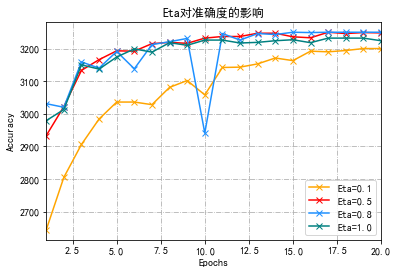

In [125]:
Eta_analysis()

In [126]:
# 完工啦！

In [127]:
# 最优神经网络的参数

layers = [22,65,100,2]
epochs = 30
mini_batch = 10
eta = 0.5
lmbda = 0.05

best_fit_paras = Network(layers, cost=QuadraticCost)
best_fit_paras.large_weight_initializer()#先要初始化
test_of_accuracy_one = best_fit_paras.SGD(train_datas, epochs, mini_batch, eta, evaluation_data = test_datas, monitor_evaluation_accuracy = True)

Epoch 0
Accuracy on evaluation data: 2940 / 3250
Epoch 1
Accuracy on evaluation data: 3059 / 3250
Epoch 2
Accuracy on evaluation data: 3108 / 3250
Epoch 3
Accuracy on evaluation data: 3164 / 3250
Epoch 4
Accuracy on evaluation data: 3176 / 3250
Epoch 5
Accuracy on evaluation data: 3192 / 3250
Epoch 6
Accuracy on evaluation data: 3200 / 3250
Epoch 7
Accuracy on evaluation data: 3237 / 3250
Epoch 8
Accuracy on evaluation data: 3214 / 3250
Epoch 9
Accuracy on evaluation data: 3239 / 3250
Epoch 10
Accuracy on evaluation data: 3249 / 3250
Epoch 11
Accuracy on evaluation data: 3246 / 3250
Epoch 12
Accuracy on evaluation data: 3250 / 3250
Epoch 13
Accuracy on evaluation data: 3246 / 3250
Epoch 14
Accuracy on evaluation data: 3249 / 3250
Epoch 15
Accuracy on evaluation data: 1970 / 3250
Epoch 16
Accuracy on evaluation data: 3250 / 3250
Epoch 17
Accuracy on evaluation data: 3243 / 3250
Epoch 18
Accuracy on evaluation data: 3250 / 3250
Epoch 19
Accuracy on evaluation data: 3250 / 3250
Epoch 20
A